<a href="https://colab.research.google.com/github/rollways/JD_EDA/blob/main/Churns_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from datetime import datetime,timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb

product_consumption = pd.read_csv('/content/drive/MyDrive/T大使/流失率data/Course product consumption amount.csv')
#會員最後一次購買日跟總金額
product_consumption_cnt = pd.read_csv('/content/drive/MyDrive/T大使/流失率data/Number of consumption.csv')
#每個會員的購買次數
done_course_count = pd.read_csv('/content/drive/MyDrive/T大使/流失率data/Number of physical exercise classes.csv')
#已經完成課程的次數，分成臉跟身體
visits_count = pd.read_csv('/content/drive/MyDrive/T大使/流失率data/Number of visits.csv')
#每個會員這段時間內回店的次數
Remaining_course_count = pd.read_csv('/content/drive/MyDrive/T大使/流失率data/Remaining number of classes.csv')
#這個會員剩下課程的堂數，分成臉跟身體
transfer_store = pd.read_csv('/content/drive/MyDrive/T大使/流失率data/Transfer store.csv')
#會員轉店次數
Customer_feeback = pd.read_csv('/content/drive/MyDrive/T大使/流失率data/complain+call customer.csv')
#每個會員回饋次數跟電話訪問(call)次數

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
product_consumption

,member_code,member,final_consumption_date,course_amount,product_amount
0,9100000013183,詹閔淳,2021-07-21 00:00:00,13946.0,4524.0
1,9100000021898,潘靜,2021-08-27 00:00:00,9476.0,13580.0
2,9100000023069,張丹,2021-09-02 00:00:00,15479.0,1927.0
3,9100000219776,黃偉婷,2020-11-02 00:00:00,2279.0,19320.0
4,9100000388762,謝怡璇,2019-11-27 00:00:00,7719.0,5864.0
...,...,...,...,...,...
7647,9100003057047,蕭存庭,2021-08-13 00:00:00,3000.0,0.0
7648,9100003057054,吳雅惠,2021-09-06 00:00:00,7440.0,557.0
7649,9100003057177,賴湘昀,2021-02-04 00:00:00,3000.0,0.0
7650,9100003057306,林雅文,2020-12-31 00:00:00,7440.0,557.0


### Data wrangling

In [77]:
product_consumption["final_consumption_date"] = pd.to_datetime(product_consumption['final_consumption_date'])

In [78]:
Member_attributes = pd.DataFrame(product_consumption['member_code'].unique())
Member_attributes.columns = ['member_code']

In [79]:
#merge with product_consumption
Member_attributes = pd.merge(Member_attributes, product_consumption[['member_code','member','final_consumption_date','course_amount','product_amount']],on='member_code',how='left')
#merge with product_consumption_cnt
Member_attributes = pd.merge(Member_attributes, product_consumption_cnt[['member_code','consumption_num']],on='member_code',how='left')
#merge with done_course_count
Member_attributes = pd.merge(Member_attributes, done_course_count[['member_code','done_face_count','done_body_count']],on='member_code',how='left')
#merge with visits_count
Member_attributes = pd.merge(Member_attributes, visits_count[['member_code','back_store_cnt']],on='member_code',how='left')
#merge with Remaining_course_count
Member_attributes = pd.merge(Member_attributes, Remaining_course_count[['member_code','Remaining_face_course','Remaining_body_course']],on='member_code',how='left')
#merge with transfer_store
Member_attributes = pd.merge(Member_attributes, transfer_store[['member_code','transfer_cnt']],on='member_code',how='left')
#merge with Customer_feeback
Member_attributes = pd.merge(Member_attributes, Customer_feeback[['member_code','complaints_cnt','CALL_cnt']],on='member_code',how='left')

In [80]:
Member_attributes

,member_code,member,final_consumption_date,course_amount,product_amount,consumption_num,done_face_count,done_body_count,back_store_cnt,Remaining_face_course,Remaining_body_course,transfer_cnt,complaints_cnt,CALL_cnt
0,9100000013183,詹閔淳,2021-07-21,13946.0,4524.0,3.0,9.0,3.0,10,6.0,0.0,NaN,0.0,9.0
1,9100000021898,潘靜,2021-08-27,9476.0,13580.0,7.0,3.0,6.0,13,0.0,0.0,NaN,NaN,NaN
2,9100000023069,張丹,2021-09-02,15479.0,1927.0,10.0,0.0,35.0,18,0.0,0.0,NaN,0.0,2.0
3,9100000219776,黃偉婷,2020-11-02,2279.0,19320.0,5.0,3.0,16.0,11,2.0,0.0,NaN,NaN,NaN
4,9100000388762,謝怡璇,2019-11-27,7719.0,5864.0,4.0,1.0,9.0,10,0.0,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647,9100003057047,蕭存庭,2021-08-13,3000.0,0.0,1.0,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN
7648,9100003057054,吳雅惠,2021-09-06,7440.0,557.0,1.0,0.0,1.0,1,1.0,5.0,NaN,NaN,NaN
7649,9100003057177,賴湘昀,2021-02-04,3000.0,0.0,1.0,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN
7650,9100003057306,林雅文,2020-12-31,7440.0,557.0,1.0,NaN,NaN,1,1.0,6.0,NaN,NaN,NaN


In [81]:
Member_attributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7652 entries, 0 to 7651
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   member_code             7652 non-null   int64         
 1   member                  7652 non-null   object        
 2   final_consumption_date  7589 non-null   datetime64[ns]
 3   course_amount           7652 non-null   float64       
 4   product_amount          7652 non-null   float64       
 5   consumption_num         7609 non-null   float64       
 6   done_face_count         7285 non-null   float64       
 7   done_body_count         7285 non-null   float64       
 8   back_store_cnt          7652 non-null   int64         
 9   Remaining_face_course   7620 non-null   float64       
 10  Remaining_body_course   7620 non-null   float64       
 11  transfer_cnt            117 non-null    float64       
 12  complaints_cnt          195 non-null    float64 

### Add Churns

In [82]:
from datetime import date 
now = datetime.now()
now = pd.to_datetime(now.strftime('%Y-%m-%d'))


Member_attributes["Churns"] = 0
Member_attributes.loc[(now - Member_attributes['final_consumption_date']).dt.days > 365,"Churns" ] = 1
Member_attributes

,member_code,member,final_consumption_date,course_amount,product_amount,consumption_num,done_face_count,done_body_count,back_store_cnt,Remaining_face_course,Remaining_body_course,transfer_cnt,complaints_cnt,CALL_cnt,Churns
0,9100000013183,詹閔淳,2021-07-21,13946.0,4524.0,3.0,9.0,3.0,10,6.0,0.0,NaN,0.0,9.0,0
1,9100000021898,潘靜,2021-08-27,9476.0,13580.0,7.0,3.0,6.0,13,0.0,0.0,NaN,NaN,NaN,0
2,9100000023069,張丹,2021-09-02,15479.0,1927.0,10.0,0.0,35.0,18,0.0,0.0,NaN,0.0,2.0,0
3,9100000219776,黃偉婷,2020-11-02,2279.0,19320.0,5.0,3.0,16.0,11,2.0,0.0,NaN,NaN,NaN,1
4,9100000388762,謝怡璇,2019-11-27,7719.0,5864.0,4.0,1.0,9.0,10,0.0,4.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647,9100003057047,蕭存庭,2021-08-13,3000.0,0.0,1.0,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN,0
7648,9100003057054,吳雅惠,2021-09-06,7440.0,557.0,1.0,0.0,1.0,1,1.0,5.0,NaN,NaN,NaN,0
7649,9100003057177,賴湘昀,2021-02-04,3000.0,0.0,1.0,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN,0
7650,9100003057306,林雅文,2020-12-31,7440.0,557.0,1.0,NaN,NaN,1,1.0,6.0,NaN,NaN,NaN,1


In [83]:
#Member_attributes['consumption_num'] = Member_attributes['consumption_num'].fillna(0)
#Member_attributes['done_face_count'] = Member_attributes['done_face_count'].fillna(0)
#Member_attributes['done_body_count'] = Member_attributes['done_body_count'].fillna(0)
#Member_attributes['Remaining_face_course'] = Member_attributes['Remaining_face_course'].fillna(0)
#Member_attributes['Remaining_body_course'] = Member_attributes['Remaining_body_course'].fillna(0)
#Member_attributes['transfer_cnt'] = Member_attributes['transfer_cnt'].fillna(0)
#Member_attributes['complaints_cnt'] = Member_attributes['complaints_cnt'].fillna(0)
#Member_attributes['CALL_cnt'] = Member_attributes['CALL_cnt'].fillna(0)

Member_attributes = Member_attributes.fillna(0)

In [84]:
Member_attributes.isna().any()

member_code               False
member                    False
final_consumption_date    False
course_amount             False
product_amount            False
consumption_num           False
done_face_count           False
done_body_count           False
back_store_cnt            False
Remaining_face_course     False
Remaining_body_course     False
transfer_cnt              False
complaints_cnt            False
CALL_cnt                  False
Churns                    False
dtype: bool

In [85]:
Member_attributes["Churns"].value_counts()

1    3891
0    3761
Name: Churns, dtype: int64

In [86]:
Member_attributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7652 entries, 0 to 7651
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   member_code             7652 non-null   int64  
 1   member                  7652 non-null   object 
 2   final_consumption_date  7652 non-null   object 
 3   course_amount           7652 non-null   float64
 4   product_amount          7652 non-null   float64
 5   consumption_num         7652 non-null   float64
 6   done_face_count         7652 non-null   float64
 7   done_body_count         7652 non-null   float64
 8   back_store_cnt          7652 non-null   int64  
 9   Remaining_face_course   7652 non-null   float64
 10  Remaining_body_course   7652 non-null   float64
 11  transfer_cnt            7652 non-null   float64
 12  complaints_cnt          7652 non-null   float64
 13  CALL_cnt                7652 non-null   float64
 14  Churns                  7652 non-null   

In [87]:
corr_matrix = Member_attributes.corr()
corr_matrix

,member_code,course_amount,product_amount,consumption_num,done_face_count,done_body_count,back_store_cnt,Remaining_face_course,Remaining_body_course,transfer_cnt,complaints_cnt,CALL_cnt,Churns
member_code,1.000000,-0.069438,-0.035362,-0.168216,-0.147522,-0.126992,-0.202540,0.017709,-0.008896,-0.017648,-0.004486,-0.061836,-0.093638
course_amount,-0.069438,1.000000,0.769120,0.673949,0.547106,0.769793,0.731785,0.606095,0.816774,0.080653,0.021122,0.127675,-0.269406
product_amount,-0.035362,0.769120,1.000000,0.434410,0.347061,0.601437,0.464311,0.475353,0.783315,0.054248,0.011030,0.046143,-0.149657
consumption_num,-0.168216,0.673949,0.434410,1.000000,0.588723,0.672472,0.865364,0.377631,0.450961,0.094403,0.009410,0.059141,-0.317461
done_face_count,-0.147522,0.547106,0.347061,0.588723,1.000000,0.341319,0.695248,0.520579,0.191696,0.080998,0.023563,0.118789,-0.164241
done_body_count,-0.126992,0.769793,0.601437,0.672472,0.341319,1.000000,0.787348,0.205822,0.634809,0.088267,0.010147,0.057671,-0.190945
back_store_cnt,-0.202540,0.731785,0.464311,0.865364,0.695248,0.787348,1.000000,0.362272,0.454412,0.107452,0.014695,0.055144,-0.267524
Remaining_face_course,0.017709,0.606095,0.475353,0.377631,0.520579,0.205822,0.362272,1.000000,0.363387,0.071247,0.014816,0.074945,-0.226466
Remaining_body_course,-0.008896,0.816774,0.783315,0.450961,0.191696,0.634809,0.454412,0.363387,1.000000,0.033464,0.009009,0.035685,-0.209975
transfer_cnt,-0.017648,0.080653,0.054248,0.094403,0.080998,0.088267,0.107452,0.071247,0.033464,1.000000,0.033966,0.030212,-0.032765


In [88]:
from sklearn.model_selection import train_test_split
#creat feature set and labels
X = Member_attributes.drop(['Churns','member','member_code','final_consumption_date'],axis=1)
y = Member_attributes.Churns
#train and test split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=56)

In [89]:
#build the model
xgb_model = xgb.XGBClassifier(max_depth=5,learning_rate=0.08,objective='binary:logistic',n_jobs=-1).fit(X_train,y_train)

print('Accuracy of XGB classifier on training set:{:.2f}'
    .format(xgb_model.score(X_train,y_train)))
print('Accuracy of XGB classifier on test set:{:.2f}'
    .format(xgb_model.score(X_test[X_train.columns],y_test)))

Accuracy of XGB classifier on training set:0.75
Accuracy of XGB classifier on test set:0.67


In [91]:
from sklearn.metrics import classification_report
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1105
           1       0.68      0.70      0.69      1191

    accuracy                           0.67      2296
   macro avg       0.67      0.67      0.67      2296
weighted avg       0.67      0.67      0.67      2296



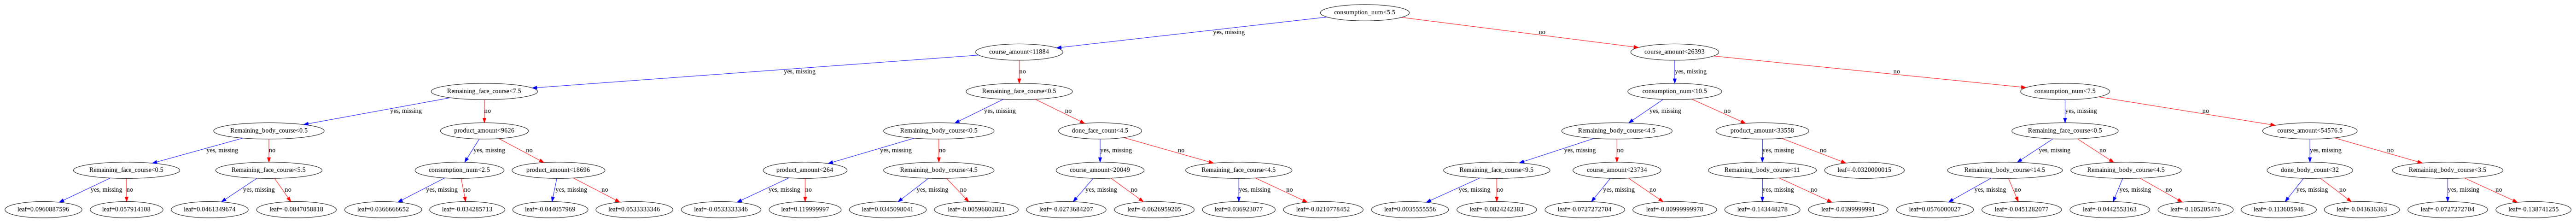

In [92]:
from xgboost import plot_tree

##set up the parameters
fig,ax=plt.subplots(figsize=(100,100))
plot_tree(xgb_model,ax=ax)

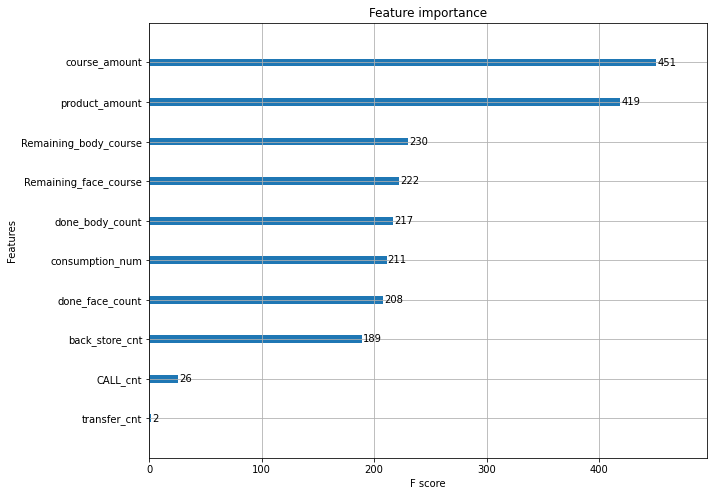

In [94]:
from xgboost import plot_importance

fig, ax=plt.subplots(figsize=(10,8))
plot_importance(xgb_model,ax=ax)